In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
companies = pd.read_csv('sp500_companies.csv')
companies[companies['Sector'] == 'Technology']
symbols = companies[companies['Sector'] == 'Technology']['Symbol']

In [3]:
data = pd.read_csv('sp500_stocks.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[data['Symbol'].isin(symbols)]
data_full = data.copy()
# use dates from 2022 and onwards
data = data[data.index.year >= 2022]
summary = data.describe()

In [4]:
data.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2022-01-03,ACN,406.156982,407.209991,415.529999,405.040009,414.660004,2129900.0
2022-01-04,ACN,403.254517,404.299988,411.369995,403.200012,408.809998,2516300.0
2022-01-05,ACN,396.152924,397.179993,403.970001,397.100006,403.929993,2471400.0
2022-01-06,ACN,377.022522,378.000000,392.200012,375.760010,384.690002,4386600.0
2022-01-07,ACN,369.791290,370.750000,379.989990,370.140015,379.089996,3469000.0


In [5]:
summary

,Adj Close,Close,High,Low,Open,Volume
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,4.309200e+04
mean,197.855936,198.689662,201.405825,195.820898,198.584621,6.816176e+06
std,174.288614,174.296987,176.741919,171.696053,174.178628,1.534457e+07
min,11.980000,11.980000,12.180000,11.900000,12.010000,3.600000e+04
25%,75.527332,76.459999,77.397501,75.389999,76.385000,8.033000e+05
50%,145.179993,146.044998,147.820007,144.034996,145.850006,1.920150e+06
75%,271.690002,272.372498,276.087486,268.187492,272.084991,4.856450e+06
max,1407.010010,1407.010010,1438.170044,1385.189941,1403.150024,3.642318e+08


In [6]:
# for each stock calculate pct_change
from tqdm import tqdm
results = []
for symbol in tqdm(data['Symbol'].unique()):
    stock = data[data['Symbol'] == symbol]
    percent_change = stock['Adj Close'].pct_change()
    returns = np.mean(percent_change) * 252
    volatility = np.std(percent_change) * np.sqrt(252)
    results.append((symbol, returns, volatility))


# create a new dataframe with tuples
volatility_df = pd.DataFrame(results, columns=['Symbol', 'Returns', 'Volatility'])


  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 76/76 [00:00<00:00, 295.42it/s]


c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:831: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:690: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:691: FutureWarning: Cal

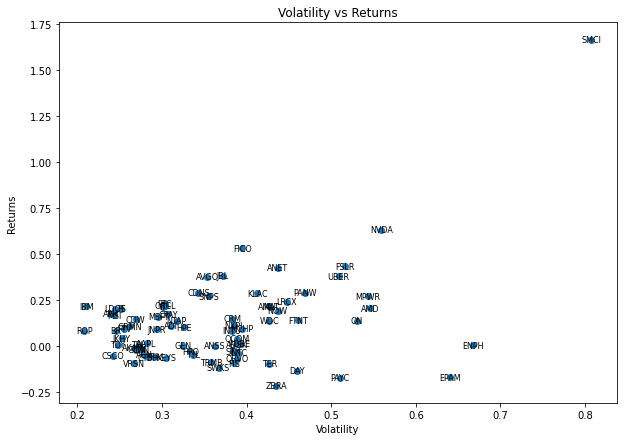

In [7]:
# plot the data
plt.figure(figsize=(10, 7))
plt.scatter(volatility_df['Volatility'], volatility_df['Returns'])
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns')
tickers = np.unique(volatility_df['Symbol'])
for i, ticker in enumerate(tickers):
    return_i = volatility_df['Returns'][volatility_df['Symbol'] == ticker]
    volatility_i = volatility_df['Volatility'][volatility_df['Symbol'] == ticker]
    plt.text(volatility_i, return_i, ticker, fontsize=8, ha='center', va='center')
plt.show()

In [8]:
import statsmodels.api as sm
X = volatility_df['Volatility']
y = volatility_df['Returns']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


print('-------------')

print(results.wald_test_terms(skip_single=False))


                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     17.01
Date:                Wed, 08 May 2024   Prob (F-statistic):           9.61e-05
Time:                        17:03:54   Log-Likelihood:                 7.4565
No. Observations:                  76   AIC:                            -10.91
Df Residuals:                      74   BIC:                            -6.252
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2251      0.088     -2.546      0.0

c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:1914: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


The coefficient for Volatility has a very small p-value (far less than 0.05), suggesting that it is highly statistically significant.
The high F-statistic value reinforces the strength of the evidence against the null hypothesis that this coefficient equals zero.
Since the test statistic is positive and the coefficient is typically modeled to show the impact on returns, this implies that higher volatility is associated with a significant change in the S&P 500 returns. The exact nature (positive or negative) of this change depends on the sign of the coefficient, which isn't shown in the F-statistic table but would be evident in the full regression output.

c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:831: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:690: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:691: FutureWarning: Cal

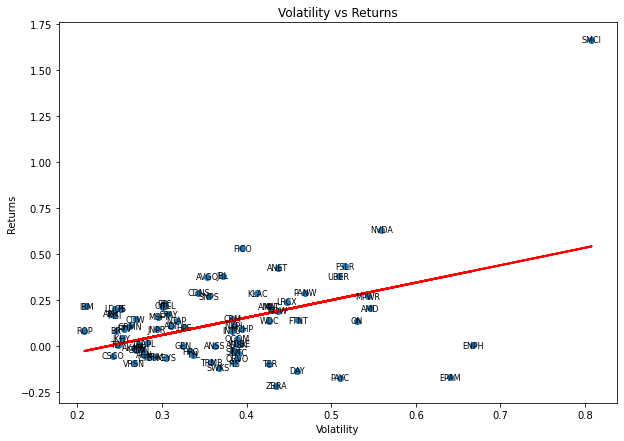

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(volatility_df['Volatility'], volatility_df['Returns'])
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns')

# Calculate the line of best fit
slope, intercept = np.polyfit(volatility_df['Volatility'], volatility_df['Returns'], 1)
line = slope * volatility_df['Volatility'] + intercept

# Plot the line of best fit
plt.plot(volatility_df['Volatility'], line, color='red', linewidth=2)  # Add the regression line

# Annotate each point with its ticker symbol
tickers = np.unique(volatility_df['Symbol'])
for i, ticker in enumerate(tickers):
    return_i = volatility_df['Returns'][volatility_df['Symbol'] == ticker]
    volatility_i = volatility_df['Volatility'][volatility_df['Symbol'] == ticker]
    plt.text(volatility_i, return_i, ticker, fontsize=8, ha='center', va='center')

plt.show()


In [10]:
from scipy import stats
data_full = data_full.dropna()
stat, p_value = stats.mannwhitneyu(data_full['Adj Close'].values, data_full['Close'].values)
print(p_value)

5.678308864297943e-154


In [11]:
sample = data_full.sample(30)
stat, p_value = stats.ttest_rel(sample['Adj Close'].values, sample['Close'].values)
print(p_value)

diff = data_full['Adj Close'] - data_full['Close']
mean_diff = np.mean(diff)
std_diff = np.std(diff)
cohen_d = mean_diff / std_diff
print(cohen_d)


5.442674019948931e-05
-0.5394155692131971


In [12]:
sample = data_full.sample(30)
differences = sample['Adj Close'] - sample['Close']
stat, p_value = stats.wilcoxon(differences)
print(p_value)

0.0006549583433856954


Wilcoxon Test Statistic: 0.0, P-value: 0.0
Effect Size (Cohen's d): -0.5394155692131971


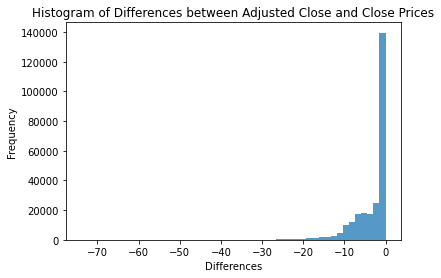

In [13]:
import numpy as np
from scipy import stats

# Calculate differences
differences = data_full['Adj Close'].values - data_full['Close'].values

# Non-parametric test
w_stat, w_p_value = stats.wilcoxon(data_full['Adj Close'].values, data_full['Close'].values)
print(f'Wilcoxon Test Statistic: {w_stat}, P-value: {w_p_value}')

# Calculate effect size (Cohen's d for paired samples)
mean_diff = np.mean(differences)
std_diff = np.std(differences)
effect_size = mean_diff / std_diff
print(f'Effect Size (Cohen\'s d): {effect_size}')

# Plotting the differences
import matplotlib.pyplot as plt
plt.hist(differences, bins=50, alpha=0.75)
plt.title('Histogram of Differences between Adjusted Close and Close Prices')
plt.xlabel('Differences')
plt.ylabel('Frequency')
plt.show()


Using Time Series Clustering

In [14]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HamadAlHammadi\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [15]:
req_data = data_full[['Symbol', 'Adj Close']]

In [16]:
req_data = req_data.pivot_table(index='Symbol', columns='Date', values='Adj Close')

In [17]:
req_data.fillna(method='ffill', axis=1, inplace=True)

C:\Users\HamadAlHammadi\AppData\Local\Temp\ipykernel_94152\1019340018.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  req_data.fillna(method='ffill', axis=1, inplace=True)


In [18]:
req_data.dropna(inplace=True)

In [19]:
req_data = req_data.T

In [20]:
req_data.head()

Symbol,AAPL,ACN,ADBE,ADI,ADSK,AKAM,AMAT,AMD,ANSS,APH,...,SWKS,TDY,TEL,TER,TRMB,TXN,TYL,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.470740,32.970871,37.090000,22.530373,25.670000,25.920000,11.205505,9.70,44.639999,10.223090,...,13.396246,39.500000,18.869904,10.162032,12.825,19.275860,20.299999,21.007998,35.536190,28.670000
2010-01-05,6.481928,33.174648,37.700001,22.494801,25.280001,26.690001,11.119308,9.71,43.639999,10.009466,...,13.604149,39.299999,18.590967,10.199118,12.760,19.164692,20.780001,21.228777,36.478378,28.620001
2010-01-06,6.378825,33.527321,37.619999,22.452124,25.340000,26.469999,11.095800,9.57,43.349998,10.047294,...,13.477597,39.369999,18.967915,10.106399,12.725,19.023890,20.770000,20.999506,36.509796,28.400000
2010-01-07,6.367033,33.495968,36.889999,22.274265,25.480000,26.480000,10.978258,9.47,43.459999,9.980539,...,13.323930,39.880001,18.613579,10.162032,12.745,19.083174,20.500000,20.710794,35.795292,27.690001
2010-01-08,6.409362,33.362751,36.689999,22.402323,26.260000,26.480000,11.401402,9.43,43.759998,10.053971,...,13.558953,40.299999,18.847294,10.273292,12.845,19.520420,20.740000,20.872133,35.975883,27.600000


In [21]:
close_prices = req_data.values

In [22]:
x_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)

In [23]:
x_train.shape

(61, 3588, 1)

In [24]:
x_train.T.shape

(1, 3588, 61)

In [25]:
req_data.shape

(3588, 61)

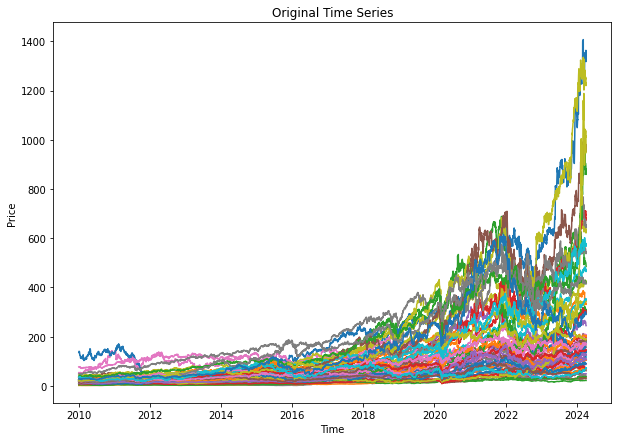

In [26]:
# plot the original time series
orig_data = req_data.T
plt.figure(figsize=(10, 7))
for i in range(orig_data.shape[0]):
    plt.plot(orig_data.iloc[i, :])
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

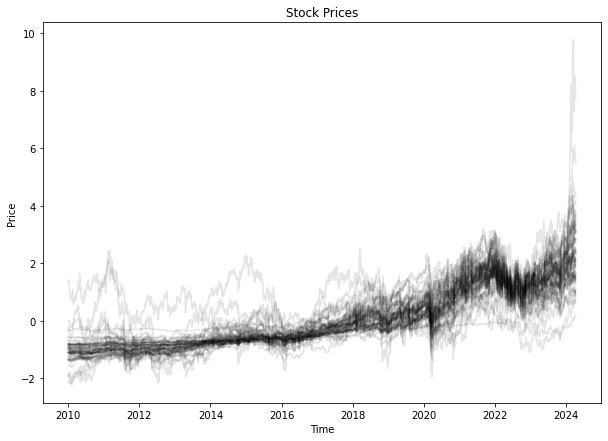

In [27]:
# plot the data
plt.figure(figsize=(10, 7))
# plot each time series
date = pd.to_datetime(req_data.index)
for i in range(x_train.shape[0]):
    #plt.plot(x_train[i].ravel(), 'k-', alpha=0.1)
    plt.plot(date, x_train[i].ravel(), 'k-', alpha=0.1)
    

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices')
plt.show()

In [28]:
from sklearn.metrics import silhouette_score
silhs = []
for i in range(4, 6):
    model = TimeSeriesKMeans(n_clusters=i, verbose=True,metric="dtw")
    y_pred = model.fit_predict(x_train)
    silh = silhouette_score(x_train.reshape(x_train.shape[0], -1), y_pred)
    silhs.append(silh)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s


189.940 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.8s


42.554 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.0s


42.002 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.9s


42.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s


42.000 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.1s


ValueError: Found array with dim 3. None expected <= 2.

In [48]:
date.shape

(3588,)

In [32]:
y_pred.shape

(61,)

In [38]:
from sklearn.metrics import silhouette_score
silhouette_score(x_train.reshape(x_train.shape[0], -1), y_pred)

0.32259556331904665

Cluster 1: Index(['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANSS',
       'APH', 'AVGO', 'BR', 'CDNS', 'CRM', 'CSCO', 'FI', 'FICO', 'FTNT', 'GEN',
       'GLW', 'GRMN', 'HPQ', 'INTC', 'INTU', 'IT', 'JBL', 'JKHY', 'KLAC',
       'LDOS', 'LRCX', 'MCHP', 'MPWR', 'MSFT', 'MSI', 'MU', 'ON', 'ORCL',
       'PTC', 'QCOM', 'ROP', 'SNPS', 'STX', 'TDY', 'TEL', 'TER', 'TRMB', 'TXN',
       'TYL', 'VRSN', 'ZBRA'],
      dtype='object', name='Symbol')
Cluster 2: Index(['NVDA', 'SMCI'], dtype='object', name='Symbol')
Cluster 3: Index(['CTSH', 'FFIV', 'FIS', 'FSLR', 'IBM', 'JNPR', 'NTAP', 'SWKS', 'WDC'], dtype='object', name='Symbol')


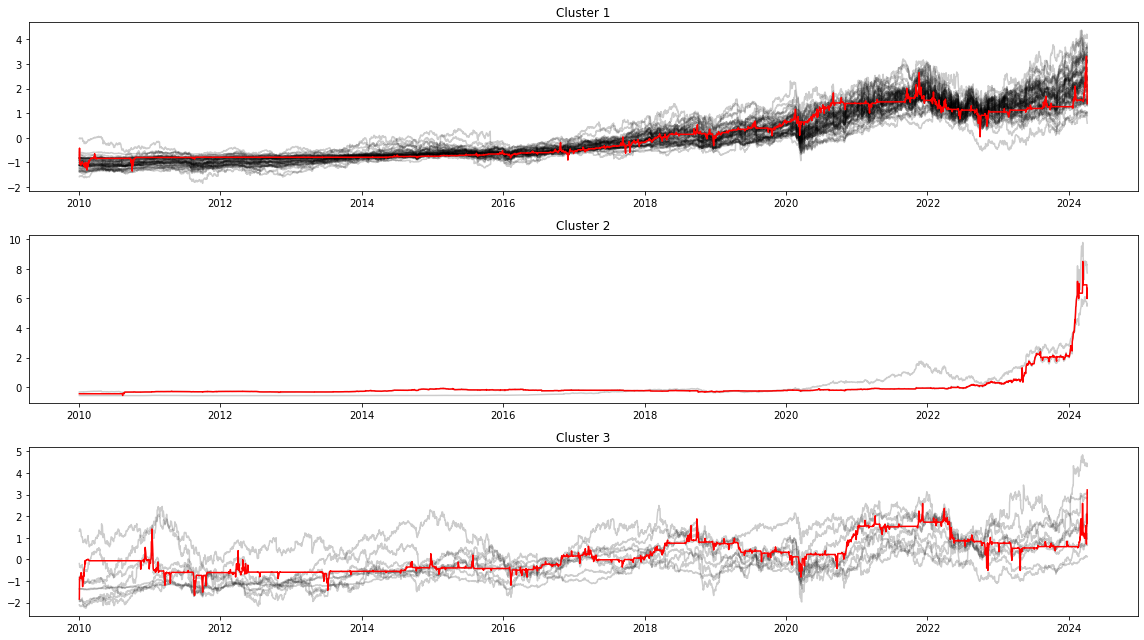

In [30]:
my_list = []
n_clusters = 3
plt.figure(figsize=(16, 9))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in x_train[y_pred == yi]:
        #plt.plot(xx.ravel(), "k-", alpha=.2)
        # plot the time series with the date, map each date with a number
        date = pd.to_datetime(req_data.index)
        plt.plot(date, xx.ravel(), "k-", alpha=.2)

    # show which stock names are corresponding to each cluster
    tickers = req_data.columns
    my_list.append(tickers[y_pred == yi])
    print(f'Cluster {yi + 1}: {tickers[y_pred == yi]}')



    plt.plot(date, model.cluster_centers_[yi].ravel(), "r-")

    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [101]:
def get_common_stocks_by_sector(first_file_path, second_file_path, sector):
    # Load both datasets
    df1 = pd.read_csv(first_file_path)
    df2 = pd.read_csv(second_file_path)
    
    # Filter the first DataFrame for the specified sector
    sector_stocks = df1[df1['Sector'] == sector]['Symbol']
    
    # Get stocks present in the second DataFrame
    common_stocks = sector_stocks[sector_stocks.isin(df2['Name'])].tolist()
    
    return common_stocks

# Example usage
first_file_path = 'sp500_companies.csv'
second_file_path = 'all_stocks_5yr.csv'
sector = "Technology"
common_stocks_in_sector = get_common_stocks_by_sector(first_file_path, second_file_path, sector)
print(common_stocks_in_sector)

['MSFT', 'AAPL', 'NVDA', 'AVGO', 'ORCL', 'CRM', 'AMD', 'ADBE', 'ACN', 'CSCO', 'QCOM', 'INTU', 'IBM', 'AMAT', 'INTC', 'TXN', 'MU', 'LRCX', 'ADI', 'KLAC', 'SNPS', 'CDNS', 'APH', 'MSI', 'ROP', 'ADSK', 'MCHP', 'TEL', 'FIS', 'IT', 'CTSH', 'ANSS', 'FTV', 'HPQ', 'GRMN', 'GLW', 'WDC', 'HPE', 'NTAP', 'VRSN', 'STX', 'SWKS', 'AKAM', 'JNPR', 'FFIV', 'QRVO']


In [102]:
common_stocks_in_sector

['MSFT',
 'AAPL',
 'NVDA',
 'AVGO',
 'ORCL',
 'CRM',
 'AMD',
 'ADBE',
 'ACN',
 'CSCO',
 'QCOM',
 'INTU',
 'IBM',
 'AMAT',
 'INTC',
 'TXN',
 'MU',
 'LRCX',
 'ADI',
 'KLAC',
 'SNPS',
 'CDNS',
 'APH',
 'MSI',
 'ROP',
 'ADSK',
 'MCHP',
 'TEL',
 'FIS',
 'IT',
 'CTSH',
 'ANSS',
 'FTV',
 'HPQ',
 'GRMN',
 'GLW',
 'WDC',
 'HPE',
 'NTAP',
 'VRSN',
 'STX',
 'SWKS',
 'AKAM',
 'JNPR',
 'FFIV',
 'QRVO']

In [63]:
for idx, elem in enumerate(my_list):
    my_list[idx] = elem.tolist()



In [103]:
new_my_list = []
for i in my_list:
    arr_new = []
    for j in i:
        if j in common_stocks_in_sector:
            arr_new.append(j)
    new_my_list.append(arr_new)



In [104]:
for cluster in new_my_list:
    print(f"cluster {new_my_list.index(cluster) + 1}: {cluster}")

cluster 1: ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AMAT', 'AMD', 'ANSS', 'APH', 'AVGO', 'CDNS', 'CRM', 'CSCO', 'GLW', 'GRMN', 'INTU', 'IT', 'KLAC', 'LRCX', 'MCHP', 'MSFT', 'MSI', 'ORCL', 'QCOM', 'ROP', 'SNPS', 'TEL', 'TXN', 'VRSN']
cluster 2: ['NVDA']
cluster 3: ['HPQ', 'IBM', 'JNPR', 'MU', 'NTAP', 'STX']
cluster 4: ['AKAM', 'CTSH', 'FFIV', 'FIS', 'INTC', 'SWKS', 'WDC']


In [82]:
data_full = data_full[data_full['Symbol'] == 'NVDA']

In [83]:
# select the following columns Date,Open,High,Low,Close,Adj Close,Volume
data_full = data_full[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

In [84]:
data_full

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,4.627500,4.655000,4.527500,4.622500,4.247546,80020400.0
2010-01-05,4.605000,4.740000,4.605000,4.690000,4.309570,72864800.0
2010-01-06,4.687500,4.730000,4.642500,4.720000,4.337137,64916800.0
2010-01-07,4.695000,4.715000,4.592500,4.627500,4.252139,54779200.0
2010-01-08,4.590000,4.670000,4.562500,4.637500,4.261328,47816800.0
...,...,...,...,...,...,...
2024-04-01,902.989990,922.250000,892.039978,903.630005,903.630005,45244100.0
2024-04-02,884.479980,900.940002,876.200012,894.520020,894.520020,43306400.0
2024-04-03,884.840027,903.739990,884.000000,889.640015,889.640015,37006700.0


In [85]:
data_full = data_full.dropna()

In [88]:
data_full.to_csv('nvda.csv', index=True)